# Project Milestone 3 Notebook
## Do Americans prefer beers with a higher alcohol content (ABV) than Europeans? 
- Is there a correlation between this preference and specific beer styles known for higher ABV?
We will use grouping techniques and micro/macro averages to analyse this preference.
- How have beer preferences, especially in terms of ABV, evolved in America and Europe between 2000 and 2017?
To analyse this question, we will use time series analysis and visualisation techniques.

## 1. Imports and global variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_gzip_txt_data

## 2. Preprocessing of the data:

#### 2.1 Load the users and split between North America and Europe:

Define European countries:

In [2]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

Load users files and classify if European, North American or neither:

In [3]:
def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'Europe'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'North America'
    else:
        return 'Other'


ba_users_df = pd.read_csv("./data/BeerAdvocate/users.csv")[['user_id', 'location']].dropna()
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = pd.read_csv("./data/RateBeer/users.csv")[['user_id', 'location']].dropna()
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

# We only care about EU or NA users
ba_users_df = ba_users_df.query("eu_na != 'Other'").reset_index(drop=True)
rb_users_df = rb_users_df.query("eu_na != 'Other'").reset_index(drop=True)

print("BeerAdvocate:")
display(ba_users_df)
print("RateBeer:")
display(rb_users_df)

BeerAdvocate:


,user_id,location,eu_na
0,nmann08.184925,"United States, Washington",North America
1,stjamesgate.163714,"United States, New York",North America
2,mdagnew.19527,Northern Ireland,Europe
3,helloloser12345.10867,Northern Ireland,Europe
4,cypressbob.3708,Northern Ireland,Europe
...,...,...,...
120486,eturchick.374415,"United States, California",North America
120487,everman.532342,"United States, California",North America
120488,justin0001.352175,"United States, California",North America
120489,joetex.800347,"United States, California",North America


RateBeer:


,user_id,location,eu_na
0,175852,Poland,Europe
1,442761,Spain,Europe
2,288889,Poland,Europe
3,250510,Spain,Europe
4,122778,Germany,Europe
...,...,...,...
46261,181614,Norway,Europe
46262,134893,England,Europe
46263,327816,Belgium,Europe
46264,82020,Slovenia,Europe


#### 2.2 Load the ratings:

Load the ratings files:

In [4]:
ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "beer_id", "date", "abv", "style", "rating"]).dropna()
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "beer_id", "date", "abv", "style", "rating"]).dropna()

Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [01:08, 2205451.87it/s]


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [01:03, 1901834.16it/s]


Cast the columns to meaningful types:

In [5]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'beer_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'beer_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

#### 2.3 Group similar beer styles into broader groups

This will make comparisons between different type of beers way easier. 

We defined the broad groups using https://www.beeradvocate.com/beer/styles/, so we can just load the csv file that we created, containing the matching specific type -> general type:

In [6]:
beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()
print(f"General styles:\n{set(beer_styles_matching.values())}")

General styles:
{'Dark Lagers', 'Stouts', 'Pale Ales', 'Wild/Sour Beers', 'Strong Ales', 'Hybrid Beers', 'Porters', 'Pale Lagers', 'Saké', 'Brown Ales', 'Wheat Beers', 'Dark Ales', 'Specialty Beers', 'Bocks', 'India Pale Ales'}


Note: we don't want to take the Saké into account as it is not a beer!

Replace the specific beer style by the general style (and drop Saké ratings):

In [7]:
def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

In [8]:
ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

In [9]:
print("BeerAdvocate:")
display(ba_ratings_df.sample(10))
print("RateBeer:")
display(rb_ratings_df.sample(10))

BeerAdvocate:


,user_id,beer_id,date,abv,style,rating
7965544,edhizdeid.749286,21683,2013-08-01,5.0,Wild/Sour Beers,5.00
3460790,sparx1100.228702,77299,2013-10-01,9.1,India Pale Ales,3.75
2506185,aficionado_shawn.735756,88,2014-08-01,6.9,India Pale Ales,4.50
3685424,redfacedshooter.657405,47151,2012-02-01,9.9,India Pale Ales,3.00
2601540,kflorence.265203,6428,2011-07-01,5.8,Pale Ales,3.33
6400106,festigio.713551,15813,2013-03-01,9.0,Stouts,4.50
1910164,jesse13713.564273,127733,2014-09-01,7.7,Bocks,3.00
2521987,chinabeergeek.152291,49281,2009-05-01,5.4,Pale Ales,3.87
6356957,stevem68.986615,145082,2015-11-01,6.0,Pale Ales,3.71
7269260,williamherbert.98404,5753,2009-05-01,6.0,Pale Ales,2.93


RateBeer:


,user_id,beer_id,date,abv,style,rating
5630325,68334,318273,2015-04-01,5.8,Pale Ales,3.3
1374546,76253,178022,2014-07-01,6.0,Hybrid Beers,4.3
1332196,33484,24348,2013-04-01,NaN,Pale Lagers,2.6
2745160,12252,16008,2006-07-01,5.0,Wheat Beers,3.2
4702884,10619,3043,2008-10-01,5.0,Brown Ales,2.9
5002397,11116,117812,2010-09-01,6.0,India Pale Ales,3.3
3044782,17111,13262,2009-04-01,4.2,Dark Lagers,3.5
2462043,24724,153247,2012-05-01,9.0,Strong Ales,3.3
693670,32671,19166,2008-04-01,5.0,Pale Lagers,2.3
4085126,120893,127065,2017-03-01,7.2,Specialty Beers,3.5


#### 2.4 Merge the users with the ratings

In [10]:
ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id', 'location'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id', 'location'])

In [11]:
print("BeerAdvocate:")
display(ba_df)
print("RateBeer:")
display(rb_df)

BeerAdvocate:


,beer_id,date,abv,style,rating,eu_na
0,142544,2015-08-01,4.5,Pale Lagers,2.88,North America
1,120824,2015-11-01,5.0,Pale Ales,3.56,North America
2,47581,2011-11-01,8.0,Strong Ales,4.50,North America
3,93113,2013-05-01,10.5,Strong Ales,3.75,North America
4,875,2015-01-01,6.0,Porters,3.81,North America
...,...,...,...,...,...,...
7806408,70471,2012-01-01,10.1,India Pale Ales,1.00,North America
7806409,70471,2014-04-01,10.1,India Pale Ales,4.54,North America
7806410,61818,2011-06-01,8.0,India Pale Ales,2.08,North America
7806411,61815,2014-05-01,6.0,Pale Ales,4.45,North America


RateBeer:


,beer_id,date,abv,style,rating,eu_na
0,410549,2016-04-01,5.0,Pale Lagers,2.0,Europe
1,105273,2015-05-01,5.2,Pale Lagers,1.7,Europe
2,19445,2015-04-01,4.5,Pale Lagers,1.9,Europe
3,130299,2015-04-01,5.3,Brown Ales,3.7,Europe
4,55659,2015-11-01,6.1,Brown Ales,2.5,Europe
...,...,...,...,...,...,...
6636932,166447,2014-07-01,5.0,Pale Lagers,2.6,Europe
6636933,85893,2008-09-01,4.7,Pale Lagers,0.5,Europe
6636934,77389,2008-09-01,4.5,Dark Lagers,3.9,Europe
6636935,5423,2008-09-01,4.0,Pale Lagers,2.7,Europe


In [12]:
del ba_ratings_df
del ba_users_df
del rb_ratings_df
del rb_users_df

#### 2.5 Get the general style of all beers

Load all beers and keep only the id, the (specific) style and the ABV:

In [13]:
ba_beers_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['beer_id', 'style', 'abv', 'brewery_id']].dropna()
rb_beers_df = pd.read_csv("./data/RateBeer/beers.csv")[['beer_id', 'style', 'abv', 'brewery_id']].dropna()

Convert the specific style to the general style:

In [14]:
ba_beers_df['style'] = ba_beers_df.apply(specific_style_to_general, axis=1)
rb_beers_df['style'] = rb_beers_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_beers_df = ba_beers_df.query("style != 'Saké'").reset_index(drop=True)
rb_beers_df = rb_beers_df.query("style != 'Saké'").reset_index(drop=True)

In [15]:
print("BeerAdvocate:")
display(ba_beers_df)
print("RateBeer:")
display(rb_beers_df)

BeerAdvocate:


,beer_id,style,abv,brewery_id
0,166064,Pale Lagers,4.7,39912
1,166065,Pale Lagers,3.8,39912
2,166066,Pale Lagers,4.8,39912
3,166067,Pale Lagers,4.0,39912
4,166063,Pale Lagers,4.5,39912
...,...,...,...,...
244794,19142,India Pale Ales,5.6,885
244795,19141,Pale Ales,6.8,885
244796,19139,Pale Ales,5.0,885
244797,19140,Brown Ales,5.3,885


RateBeer:


,beer_id,style,abv,brewery_id
0,410549,Pale Lagers,5.0,3198
1,105273,Pale Lagers,5.2,3198
2,19445,Pale Lagers,4.5,3198
3,155699,Stouts,4.6,13538
4,239097,Pale Ales,4.2,13538
...,...,...,...,...
399889,153089,Pale Lagers,6.0,1107
399890,153086,Wheat Beers,4.8,1107
399891,220722,Pale Lagers,5.0,1107
399892,287791,Pale Lagers,4.0,1107


## 3. Merging BeerAdvocate and RateBeer

Ideally, we would like to merge both the RateBeer and BeerAdvocate datasets to have more data. Let's look at some challenges arise:

#### 3.1 Mean ratings

In [16]:
ba_mean_rating = ba_df['rating'].mean()
rb_mean_rating = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_rating:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.88.
The mean rating in RateBeer is 3.29.



#### Observations:
The mean rating is way higher in BeerAdvocate than in RateBeer.

#### 3.2 EU / NA imbalance

In [17]:
ba_eu_na_count = ba_df.groupby('eu_na')['rating'].count()
ba_eu_count = ba_eu_na_count['Europe']
ba_na_count = ba_eu_na_count['North America']
ba_total_count = ba_eu_count + ba_na_count

rb_eu_na_count = rb_df.groupby('eu_na')['rating'].count()
rb_eu_count = rb_eu_na_count['Europe']
rb_na_count = rb_eu_na_count['North America']
rb_total_count = rb_eu_count + rb_na_count

print(f'The number of ratings from EU in BeerAdvocate is {ba_eu_count} ({ba_eu_count / ba_total_count:.2%})\n'
      f'The number of ratings from NA in BeerAdvocate is {ba_na_count} ({ba_na_count / ba_total_count:.2%})\n\n'
      f'The number of ratings from EU in RateBeer is {rb_eu_count} ({rb_eu_count / rb_total_count:.2%})\n'
      f'The number of ratings from NA in RateBeer is {rb_na_count} ({rb_na_count / rb_total_count:.2%})\n')

The number of ratings from EU in BeerAdvocate is 228031 (2.92%)
The number of ratings from NA in BeerAdvocate is 7578382 (97.08%)

The number of ratings from EU in RateBeer is 3005451 (45.28%)
The number of ratings from NA in RateBeer is 3631486 (54.72%)



#### Observations:
RateBeer is pretty balanced, but BeerAdvocate is mostly used by North American users.

## 3.3 Aligning the ratings

We want to merge both datasets to have more data. To achieve this in a meaningful way, we will use (1.) the mean of EU users' ratings and (2.) the mean of NA users' ratings in both datasets. Once we have the mean rating of each continent for each dataset, we shift the ratings of BeerAdvocate so that the average of both continents' means is the same as the one from RateBeer. (It's more clean by reading the code.)

We don't want to simply align the mean ratings of the datasets because BeerAdvocate is mostly American. By using the average of the means of each continent, we remove the problem of imbalance between EU and NA.

In [18]:
# Get the mean rating for each continent in BeerAdvocate
ba_eu_na_mean = ba_df.groupby('eu_na')['rating'].mean()
ba_na_mean_rating = ba_eu_na_mean['Europe']
ba_eu_mean_rating = ba_eu_na_mean['North America']
# Take the mean of the mean of each of continent in BeerAdvocate
ba_mean_of_mean_ratings = (ba_na_mean_rating + ba_eu_mean_rating) / 2

# Get the mean rating for each continent in RateBeer
rb_eu_na_mean = rb_df.groupby('eu_na')['rating'].mean()
rb_na_mean_rating = rb_eu_na_mean['Europe']
rb_eu_mean_rating = rb_eu_na_mean['North America']
# Take the mean of the mean of each of continent in RateBeer
rb_mean_of_mean_ratings = (rb_na_mean_rating + rb_eu_mean_rating) / 2

# Shift the ratings from BeerAdvocate so that its average of means of both continents matches the one from RateBeer
ba_df['rating'] = ba_df['rating'] - ba_mean_of_mean_ratings + rb_mean_of_mean_ratings

Let's check the results:

In [19]:
# Get the mean rating for each dataset
ba_mean_rating = ba_df['rating'].mean()
rb_mean_rating = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_rating:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.38.
The mean rating in RateBeer is 3.29.



#### Observations:
The mean ratings are now more similar, but not exactly the same. This is because NA users give higher ratings than EU users, and there are way more of them in BeerAdvocate.

In [20]:
# Get the mean rating for each continent for each dataset
ba_eu_na_mean = ba_df.groupby('eu_na')['rating'].mean()
ba_eu_mean = ba_eu_na_mean['Europe']
ba_na_mean = ba_eu_na_mean['North America']

rb_eu_na_mean = rb_df.groupby('eu_na')['rating'].mean()
rb_eu_mean = rb_eu_na_mean['Europe']
rb_na_mean = rb_eu_na_mean['North America']

print(f'The mean rating from EU users in BeerAdvocate is {ba_eu_mean:.2f}\n'
      f'The mean rating from EU users in RateBeer is {rb_eu_mean:.2f}\n\n'
      f'The mean rating from NA users in BeerAdvocate is {ba_na_mean:.2f}\n'
      f'The mean rating from NA users in RateBeer is {rb_na_mean:.2f}\n')

The mean rating from EU users in BeerAdvocate is 3.17
The mean rating from EU users in RateBeer is 3.20

The mean rating from NA users in BeerAdvocate is 3.39
The mean rating from NA users in RateBeer is 3.36



#### Observations:
The ratings are now very close in both Datasets. The difference in ratings between NA and EU users is now nearly the same ! 

Note that the distribution is not exactly the same, as BeerAdvocate ratings are not contained in the interval [0.5, 5] anymore, but this is not an issue for our analysis.

#### 3.4 Merging

We now merge the two ratings datasets.


In [21]:
# Function to add a prefix to all values of a Pandas Series. 
def add_prefix_to_val(df_col: pd.Series, prefix: str):
    return prefix + df_col.astype(str)

In [22]:
# Change the id of beers to avoid duplicates
ba_df['beer_id'] = add_prefix_to_val(ba_df['beer_id'], 'ba_')
rb_df['beer_id'] = add_prefix_to_val(rb_df['beer_id'], 'rb_')

ratings_df = pd.concat([ba_df, rb_df]).reset_index(drop=True)
display(ratings_df)

,beer_id,date,abv,style,rating,eu_na
0,ba_142544,2015-08-01,4.5,Pale Lagers,2.375325,North America
1,ba_120824,2015-11-01,5.0,Pale Ales,3.055325,North America
2,ba_47581,2011-11-01,8.0,Strong Ales,3.995325,North America
3,ba_93113,2013-05-01,10.5,Strong Ales,3.245325,North America
4,ba_875,2015-01-01,6.0,Porters,3.305325,North America
...,...,...,...,...,...,...
14443345,rb_166447,2014-07-01,5.0,Pale Lagers,2.600000,Europe
14443346,rb_85893,2008-09-01,4.7,Pale Lagers,0.500000,Europe
14443347,rb_77389,2008-09-01,4.5,Dark Lagers,3.900000,Europe
14443348,rb_5423,2008-09-01,4.0,Pale Lagers,2.700000,Europe


We can also merge the datasets with the beer styles and ABV, but we need to check for the duplicates:

In [23]:
# Load matched beers dataset
matched_beers_df = (pd.read_csv("./data/matched_beer_data/beers.csv", skiprows=0, header=1)[['beer_id', 'beer_id.1']]
                    .rename(columns={'beer_id': 'ba_beer_id', 'beer_id.1': 'rb_beer_id'}))

# Merge BeerAdvocate with the matched beers dataframe
ba_matched_beers_df = ba_beers_df.merge(matched_beers_df, how='left', left_on='beer_id', right_on='ba_beer_id')[
    ['style', 'abv', 'beer_id', 'rb_beer_id', 'brewery_id']].rename(
    columns={'beer_id': 'ba_beer_id', 'brewery_id': 'ba_brewery_id'}
)

# Merge RateBeer with the merged dataframe
beers_df = rb_beers_df.merge(ba_matched_beers_df, how='outer', left_on=['beer_id', 'style', 'abv'],
                                     right_on=['rb_beer_id', 'style', 'abv'])[['style', 'abv', 'ba_beer_id', 'beer_id', 'ba_brewery_id', 'brewery_id']].rename(
    columns={'beer_id': 'rb_beer_id', 'brewery_id': 'rb_brewery_id'})

# Pandas automatically cast int to float if there are NaN in the merge. We will turn them into strings to remove the decimal part.
def remove_decimal_from_str(str_val: str):
    return str_val.split('.')[0]

beers_df = beers_df.astype({
    'ba_beer_id': str,
    'rb_beer_id': str
})

beers_df['ba_beer_id'] = beers_df['ba_beer_id'].apply(remove_decimal_from_str)
beers_df['rb_beer_id'] = beers_df['rb_beer_id'].apply(remove_decimal_from_str)

# Now we can modify the beer ids to avoid duplicates, and to match the ratings dataframe
beers_df['ba_beer_id'] = add_prefix_to_val(beers_df['ba_beer_id'], 'ba_')
beers_df['rb_beer_id'] = add_prefix_to_val(beers_df['rb_beer_id'], 'rb_')

# Remove nan values
beers_df = beers_df.replace(['ba_nan', 'rb_nan'], np.NaN)

display(beers_df)

,style,abv,ba_beer_id,rb_beer_id,ba_brewery_id,rb_brewery_id
0,Pale Lagers,5.0,NaN,rb_410549,NaN,3198.0
1,Pale Lagers,5.2,NaN,rb_105273,NaN,3198.0
2,Pale Lagers,4.5,NaN,rb_19445,NaN,3198.0
3,Stouts,4.6,ba_169948,rb_155699,40309.0,13538.0
4,Pale Ales,4.2,NaN,rb_239097,NaN,13538.0
...,...,...,...,...,...,...
608980,Dark Ales,8.1,ba_34858,NaN,565.0,NaN
608981,Pale Ales,8.5,ba_89711,NaN,23640.0,NaN
608982,Stouts,8.0,ba_141790,NaN,23640.0,NaN
608983,Pale Ales,7.0,ba_72174,NaN,23640.0,NaN


Now both the beers and ratings datasets are merged!

#### Note:

From now on, we only use the `df` dataframe and the `beers_df`. 

In [24]:
del ba_beers_df
del rb_beers_df
del matched_beers_df
del ba_matched_beers_df
del ba_df
del rb_df

## 4. General Analysis

We want to answer the following question: Do Americans prefer beers with a higher alcohol content (ABV) than Europeans? 

We will try to quantify this "preference" by looking at the differences in ratings and consumption (amount of ratings) between the two continents for different ABV. 

We start with a naive and basic analysis.

In [25]:
# Setting some seaborn parameters
sns.set_theme()
hue_order = ['North America', 'Europe']
hue_order_styles = beers_df["style"].unique()
palette = sns.color_palette("tab20")

#### 4.1 Naive Analysis

Let's check the number of reviews per rounded ABV:

[None,
 Text(0.5, 1.0, 'Distribution of number of ratings by ABV'),
 Text(0.5, 0, 'Alcohol by volume [%]')]

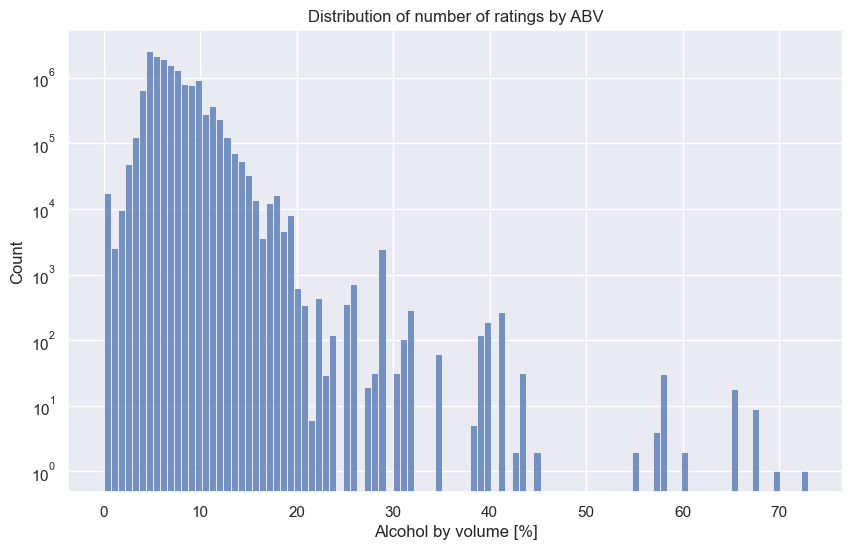

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=ratings_df, x='abv', bins=100)
ax.set(yscale='log', title="Distribution of number of ratings by ABV", xlabel="Alcohol by volume [%]")

#### Observations: 
The number of reviews for the beers with ABV > 20% is small and the histogram shows sparse values for high ABV, meaning that there are only a few beers with such ABV. Because of that, we will consider all beers above 20% ABV as one category (as if they had the same ABV).

In [27]:
# Set the maximum ABV (any ABV above this will be considered the same as max_abv) 
max_abv = 20
limited_abv_df = ratings_df[['rating', 'eu_na']].copy()
limited_abv_df['abv'] = ratings_df['abv'].apply(lambda x: x if x < max_abv else max_abv)

Now let's see the difference in the distribution of the ABV in the reviews: 

[Text(0.5, 0, 'ABV [%]'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Distribution of the ABV in the ratings')]

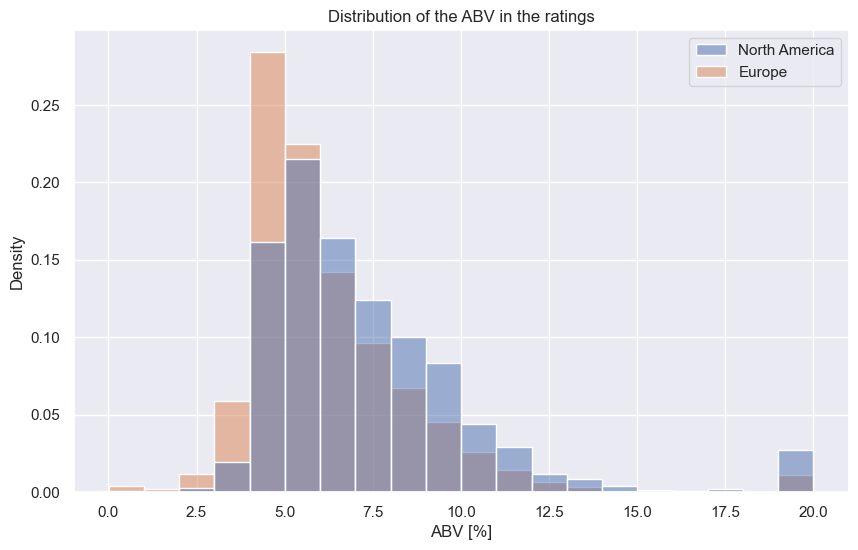

In [28]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=limited_abv_df, x='abv', bins=20, hue='eu_na', hue_order=hue_order, stat='density', common_norm=False)

ax.get_legend().set_title(None)
ax.set(xlabel="ABV [%]",
       ylabel="Density",
       title="Distribution of the ABV in the ratings")

#### Observations:

We clearly see a difference in the ABV of the beers that North American and European users are rating. The right shift in the distribution of the ABV of the ratings from North America seems to indicate that the beers consumed in North America have a higher ABV than in Europe. 


In [29]:
# Round the ABV for the following plot
rounded_abv_df = limited_abv_df.copy()
rounded_abv_df['abv'] = limited_abv_df['abv'].round()

In [30]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=rounded_abv_df, x='abv', y='rating', hue='eu_na', hue_order=hue_order)

ax.get_legend().set_title(None)
ax.set(xlabel="ABV [%]",
       ylabel="Average rating",
       title="Average rating of EU and NA users by ABV")

#### Observations:
We see that in general, North American users tend to give better ratings than European users for lighter beers with ABV < 10%, and for stronger beers, ABV > 18%. This could point to a difference in taste that depends on the ABV between NA and EU users. This might be also a difference coming from the styles that are consumed. We need to dig deeper into this!

All our previous results present a major issue: the dataset is not well balanced. Among these imbalances, we can cite:
* there are more american users' ratings than europeans';
* europeans tend to focus more on european beers, and more generally
* more european beers reviewed.

In the case where people prefer local beers, this would indeed introduce confounders. In order to mitigate that, we will perform a one-to-one matching. Since performing one-to-one matching for a large dataset is quite computationally expensive, we will only consider a subset of the data. For each beer, we will take two ratings: one from an american user and one from an european user, thus ensuring that we have as many american and european ratings.

In [ ]:
# Loading breweries to get the country of each beer
breweries_ba = pd.read_csv("./data/BeerAdvocate/breweries.csv")[['id', 'name', 'location']]
breweries_ba['id'] = add_prefix_to_val(breweries_ba['id'], 'ba_')
breweries_rb = pd.read_csv("./data/RateBeer/breweries.csv")[['id', 'name', 'location']]
breweries_rb['id'] = add_prefix_to_val(breweries_rb['id'], 'rb_')

# Merging breweries infos from both datasets
breweries_df = pd.merge(
    left=breweries_ba,
    right=breweries_rb,
    how='outer',
    left_on=['name', 'location'],
    right_on=['name', 'location'],
    suffixes=('_ba', '_rb')
)

# Getting the continent of each brewery
breweries_df['eu_na'] = breweries_df.apply(get_na_or_eu, axis=1)

# Dropping breweries that are not in EU nor NA
breweries_df = breweries_df.query("eu_na != 'Other'").reset_index(drop=True)

# Getting the continent of each beer
european_breweries = breweries_df.query("eu_na == 'Europe'").reset_index(drop=True)
american_breweries = breweries_df.query("eu_na == 'North America'").reset_index(drop=True)
european_beers = beers_df.query("(ba_brewery_id in @european_breweries['id_ba']) | (rb_brewery_id in @european_breweries['id_rb'])").reset_index(drop=True)
american_beers = beers_df.query("(ba_brewery_id in @american_breweries['id_ba']) | (rb_brewery_id in @american_breweries['id_rb'])").reset_index(drop=True)
reviews_of_european_beers = ratings_df.query("(beer_id in @european_beers['ba_beer_id']) | (beer_id in @european_beers['rb_beer_id'])").reset_index(drop=True)
reviews_of_american_beers = ratings_df.query("(beer_id in @american_beers['ba_beer_id']) | (beer_id in @american_beers['rb_beer_id'])").reset_index(drop=True)
reviews_of_european_beers['beer_eu_na'] = 'Europe'
reviews_of_american_beers['beer_eu_na'] = 'North America'
ratings_df_with_beer_continent = pd.concat([reviews_of_european_beers, reviews_of_american_beers])

# Performing the one-to-one matching
matched_ratings_df =  ratings_df_with_beer_continent \
    .groupby(['beer_id']) \
    .filter(lambda x: 'North America' in x['eu_na'].values and 'Europe' in x['eu_na'].values) \
    .groupby(['beer_id', 'eu_na']) \
    .first() \
    .sort_values(by=['beer_id'])

print("Reviews by european users: " + str(len(matched_ratings_df.query("eu_na == 'Europe'"))))
print("Reviews by american users: " + str(len(matched_ratings_df.query("eu_na == 'North America'"))))

Performing a simple linear regression on the bulk dataset and the matched one to see if the conclusions are the same.

In [ ]:
# Importing some specific modules for this task
from matplotlib.colors import LogNorm # For log-scale colorbars
import scipy

# Defining a function for a nicer legend
def get_fit_equation(
        result: scipy.stats._stats_mstats_common.LinregressResult,
        decilams: int = 2
    ) -> str:
    """Returns the equation of the regression line."""
    legend = ""
    legend += "\n" + f"Slope: {result.slope:.{decilams}f} ± {result.stderr:.{decilams}f}"
    legend += "\n" + f"Intercept: {result.intercept:.{decilams}f} ± {result.intercept_stderr:.{decilams}f}"
    legend += "\n" + f"R-squared: {result.rvalue**2:.{decilams}f}"
    return legend.strip()

dfs_ = [
    ratings_df.dropna().sample(int(1e6)), # bulk dataset, of approx. the same size than the matched dataset
    matched_ratings_df, # matched dataset
]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 9))

for df_index, df__ in enumerate(dfs_):

    fit_results = []
    
    for continent_index, continent in enumerate(['Europe', 'North America']):

        # Filtering the dataset for the current continent
        df_ = df__.query("eu_na == @continent")

        # Drawing the background histogram
        g = sns.histplot(
            data=df_,
            x="abv",
            y="rating",
            bins=30,
            cmap="plasma",
            ax=axes[df_index, continent_index],
            cbar=True,
            cbar_kws={'label': 'Number of ratings'},
            norm=LogNorm(), vmin=None, vmax=None, # Logarithmic color scale
        )

        # Drawing the regression line
        regplot = sns.regplot(
            data=df_,
            x="abv",
            y="rating",
            line_kws={'color':'r', 'alpha':1.0},
            scatter=False,
            ax=axes[df_index, continent_index],
        )

        # Computing the regression and some statistics
        x = df_['abv'].values
        y = df_['rating'].values
        result = scipy.stats.linregress(x=x, y=y)
        fit_results.append(result)

        # # Finalizing the plot
        axes[df_index, continent_index].legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
        axes[df_index, continent_index].set(
            xlim=(matched_ratings_df['abv'].min(), matched_ratings_df['abv'].max()),
            ylim=(matched_ratings_df['rating'].min(), matched_ratings_df['rating'].max()),
            title=f'{continent} ($N={len(df_)}$)',
            xlabel='ABV',
            ylabel='Rating',
        )

    axes[df_index, 2].errorbar(
        x=[0, 1],
        y=[result.slope for result in fit_results],
        yerr=[result.stderr for result in fit_results],
        fmt='ko-',
        capsize=50,
    )
    axes[df_index, 2].set(
        xticks=[0, 1],
        xticklabels=['Europe', 'America'],
        ylabel='Slope',
        xmargin=0.5, # Aesthetic
        ymargin=0.3, # Aesthetic
    )

    axes[df_index, 3].errorbar(
        x=[0, 1],
        y=[result.intercept for result in fit_results],
        yerr=[result.intercept_stderr for result in fit_results],
        fmt='ko-',
        capsize=50,
    )
    axes[df_index, 3].set(
        xticks=[0, 1],
        xticklabels=['Europe', 'America'],
        ylabel='Intercept',
        xmargin=0.5, # Aesthetic
        ymargin=0.3, # Aesthetic
    )

fig.tight_layout()
plt.show()

#### Observations:

As it can be seen in the plots above, the conclusions with and without the one-to-one matching are similar: the slope of the linear regression for Europeans is systematically and significally higher than for North Americans. This does again confirm our previous asumptions, that Europeans tend to prefer stronger beers than North Americans. But in order to make conclusions, we can investigate further by looking at different beer styles, to see if this trend is consistent across all of them.

### 4.2 Beer styles

To try to explain the plots above, let's take a look at the different beer styles and their average ABV, as well as their average ratings.
First the average ratings per style:

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=ratings_df, x='rating', y='style', hue='eu_na', hue_order=hue_order)

ax.get_legend().set_title(None)
ax.set(title='Average ratings by beer style', 
       xlim=(2, 4.5),
       xlabel='Average Rating',
       ylabel='Beer Style'
)
ax.legend(loc='upper right')

And now ABV per style:

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=beers_df, x='abv', y='style', palette=palette)
ax.set(title='Average ABV of each beer style',
       xlabel='ABV [%]',
       ylabel='Beer Style')


#### Observations:
We see that some beer styles are significantly stronger than others. If these styles are consumed more frequently on one of the two continents compared to the other, then this could explain some differences in the way ratings are correlated with ABV.

Now let's look at the number of ratings per beer style:

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=ratings_df, y='style', hue='eu_na', hue_order=hue_order)
ax.get_legend().set_title(None)
ax.legend(loc='upper right')
ax.set(title='Number of ratings per beer style',
       xlabel='Number of ratings',
       ylabel='Beer Style'
)

Let us examine the relative distribution of beer style reviews for each continent

In [ ]:
# create new df with normalised rating, color and style per continent
EU_pie = ratings_df.query("eu_na == 'Europe'").groupby('style')['rating'].count().reset_index()

# order w.r.t hue_order_styles and add color
EU_pie = EU_pie.set_index('style').reindex(hue_order_styles).reset_index()
EU_pie['color'] = [palette[x] for x in range(len(hue_order_styles))]

# repeat for North America
NA_pie = ratings_df.query("eu_na == 'North America'").groupby('style')['rating'].count().reset_index()
NA_pie = NA_pie.set_index('style').reindex(hue_order_styles).reset_index()
NA_pie['color'] = [palette[x] for x in range(len(hue_order_styles))]

# sort by rating count
EU_pie = EU_pie.sort_values(by='rating', ascending=False)
NA_pie = NA_pie.sort_values(by='rating', ascending=False)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

def draw_pie_with_legend(ax, data, title):
    """
    Draw a pie chart as donut
    :param ax: matplotlib.axes.Axes object
    :param data: pandas.DataFrame
    :param title: str
    :return: None
    """

    wedges, texts, autotexts = ax.pie(data['rating'], autopct='', startangle=0, colors=data['color'], labels=None,
                                      wedgeprops=dict(width=0.3, edgecolor='w'), radius=.9)
    ax.axis('equal')
    # Draw arrows/boxes with beer style name and percentage outside the chart
    radius = 1.05
    for i, (wedge, label, pct) in enumerate(zip(wedges, data['style'], autotexts)):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        frac = data.rating.iloc[i] / data.rating.sum()
        if label == 'Dark Ales':
            ax.text(x-0.02, y+0.038, f"{label}\n{frac:.1%}", ha='center', va='center', fontsize=11, color='black')
        else:
            ax.text(x, y, f"{label}\n{frac:.1%}", ha='center', va='center', fontsize=11, color='black')

    ax.set_title(title, fontsize=22)

# Draw pie charts for Europe and North America
draw_pie_with_legend(axes[0], EU_pie, 'Europe')
draw_pie_with_legend(axes[1], NA_pie, 'North America')

# Create a legend outside the subplots

legend = fig.legend(hue_order_styles, loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=16, title='Beer Style')
legend.get_title().set_fontsize(18)

plt.tight_layout()
plt.show()

#### Observations:

We see that, because of the merging with BeerAdvocate, there are many more reviews from North American users compared to European users. We can also see that, while the popular styles of one of continent are also mostly popular on the other one, there are still differences in the preferred styles (like IPA in NA and Pale Ales in EU). If we take into account the styles with the most ABV we see that:
- Stouts: are consumed more frequently in NA than EU.
- Strong Ales: are more popular in Europe than NA.
- Indian Pale Ales: is the most popular style in NA, not so much in EU.
- Porters: are not very popular on both continents, but more consumed in NA.
- Bocks: are not very popular on both continents.
- Dark Ales: not popular at all in Europe. 

It seems then that North American users consume more of the beers whose styles are associated with a higher average ABV (> 6%) compared to European users. This could explain why North American users drink (and so rate) more stronger beers on average than in Europeans.

As earlier, let's perform a linear regression between the ABV and the ratings, but this time for each beer style separately.

In [ ]:
styles_to_plot = ratings_df.value_counts('style').index[:3]
fig1, axes1 = plt.subplots(ncols=len(styles_to_plot), nrows=2, figsize=(10, 6), sharey=True, sharex=True)
fig2, axes2 = plt.subplots(ncols=len(styles_to_plot), nrows=2, figsize=(10, 6), sharey=False, sharex=True)

for style_index, style in enumerate(styles_to_plot):

    fit_results = []
    
    for continent_index, continent in enumerate(['Europe', 'North America']):

        # Filtering the dataset for the current continent
        df_ = matched_ratings_df.query("eu_na == @continent and style == @style")

        # Drawing the background histogram
        plt.figure(figsize=(5, 5))
        g = sns.histplot(
            data=df_,
            x="abv",
            y="rating",
            bins=20,
            cmap="plasma",
            ax=axes1[continent_index, style_index],
            cbar=True,
            norm=LogNorm(), vmin=None, vmax=None, # Logarithmic color scale
        )
        # g.set_facecolor('k')

        # Drawing the regression line
        regplot = sns.regplot(
            data=df_,
            x="abv",
            y="rating",
            line_kws={'color':'r', 'alpha':1.0},
            scatter=False,
            ax=axes1[continent_index, style_index],
        )

        # Computing the regression and some statistics
        x = df_['abv'].values
        y = df_['rating'].values
        result = scipy.stats.linregress(x=x, y=y)
        fit_results.append(result)

        # Finalizing the plot
        axes1[continent_index, style_index].set(
            xlim=(matched_ratings_df['abv'].min(), matched_ratings_df['abv'].max()),
            ylim=(matched_ratings_df['rating'].min(), matched_ratings_df['rating'].max()),
            xlabel='ABV',
            ylabel=f'{continent}\n\nAverage rating',
        )

    axes1[0, style_index].set_title(style)

    axes2[0, style_index].errorbar(
        x=[0, 1],
        y=[result.slope for result in fit_results],
        yerr=[result.stderr for result in fit_results],
        fmt='ko-',
        capsize=50,
    )
    axes2[0, style_index].set(
        xticks=[0, 1],
        xticklabels=['Europe', 'America'],
        xmargin=0.5, # Aesthetic
        ymargin=0.3, # Aesthetic
    )

    axes2[1, style_index].errorbar(
        x=[0, 1],
        y=[result.intercept for result in fit_results],
        yerr=[result.intercept_stderr for result in fit_results],
        fmt='ko-',
        capsize=25,
    )
    axes2[1, style_index].set(
        xticks=[0, 1],
        xticklabels=['Europe', 'America'],
        xmargin=0.5, # Aesthetic
        ymargin=0.3, # Aesthetic
    )
    axes2[0, style_index].set_title(style)
    
axes2[0, 0].set(ylabel='Slope')
axes2[1, 0].set(ylabel='Intercept')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

### 4.3 Evolution over time

In the following part, we compare the monthly average ratings of EU and NA users:

In [ ]:
plt.figure(figsize=(10, 6))

ax.get_legend().set_title(None)

ax = sns.lineplot(data=ratings_df, x='date', y='rating', hue='eu_na', hue_order=hue_order)
ax.get_legend().set_title(None)
ax.set(title='Monthly average ratings of Europeans and North Americans',
       xlabel='Date',
       ylabel='Average Rating',
       xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01'))
)
ax.legend()

#### Observations:
This plot shows us that North American users have basically always been more generous with the ratings than Europeans. We don't really consider the ratings before 2002 because the data is too noisy due to a small number of reviews. 
We see that the ratings are increasing over time, but there doesn't seem to be a major difference in this regard between North Americans and Europeans.


In [ ]:
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=ratings_df, x='date', y='abv', hue='eu_na', hue_order=hue_order)
ax.get_legend().set_title(None)
ax.set(xlabel="Date",
       ylabel="Alcohol by volume [%]",
       title="Monthly average of the ratings' ABV between Europeans and North Americans",
       xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
       ylim=(3.5, 10)
       )
ax.legend()

#### Observations:
This plot is very interesting, because it indicates a few things:
- We see trends for Europe as well as North America that shows increase in ABV over time.
- There also seems an aspect of seasonality which looks like ABV has peaks every start of a new year and a low each summer in both continents
- North American consumers seem to on average drink stronger beers than Europeans overall
- The ABV increases over time, for Northern Americans it increased more initially and started flattening down in mid 2010s
- The data seems to be noisier overall in Europe, in North America the seasonality pattern seems quite clear? Initial thoughts on this are that maybe European events such as Oktoberfest and St. Patricksday may actually have a big impact on this seasonality pattern
- There is a lot of noise in the first few years, which is why we'll likely remove them later for doing time series analysis

We'll use this plot as basis for a more indepth analysis on seasonality and trend. Let's first take a brief look on how ABV time series looks like for all individual beer styles to see if we can already narrow down some details

In [ ]:
# plotting ABV by Style for each continent
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

sns.lineplot(data=ratings_df.query("eu_na == 'North America'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[0], palette='tab20')
sns.lineplot(data=ratings_df.query("eu_na == 'Europe'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[1], palette='tab20')
axes[0].legend(loc='upper left')
axes[0].set(xlabel="Year",
            ylabel="Alcohol by volume [%]",
            title="North America",
            xlim=(pd.Timestamp('2001-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(4, 12))

axes[1].set(xlabel="Year",
            ylabel="Alcohol by volume [%]",
            title="Europe",
            xlim=(pd.Timestamp('2001-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(4, 12))
axes[1].get_legend().remove()

#### Observations:
When considering all the beer styles within the data, one observes seasonality within some styles such as Specialty beer or Dark ales. It is also apparent that some beer styles such as Stouts increased drastically in average ABV over time. 
We also notice that some styles seem to differ in ABV on average in both continents.

## 5. Seasonality and Trend
The main idea of this section is to decompose the time series for each region into seasonality and trend, and take a more in-depth look at the patterns and what might be causing them.\
In a first step we use statsmodels seasonal decomposition function to separate seasonality from trend


In [ ]:
import statsmodels.api as sm

In [ ]:
# define df's for Europe and North America
df_EU = ratings_df[ratings_df['eu_na'] == 'Europe']
df_NA = ratings_df[ratings_df['eu_na'] == 'North America']

# define a function that groups abv data by the month, removes NaN from abv 
def abv_by_month(df):
    """
    Groups the dataframe by month and returns a new dataframe with the average abv for each month with date as index

    :param df: pandas.Dataframe with a column "date" and a column "abv".
    :return: pandas.Dataframe with column "abv" and index date. seasonal decomposition by statsmodels requires a datetime index
    """
    df = df[(df['date'] > '2003-01-01') & (df['date'] < '2017-01-01')] # NOTE: CONSIDER SPECIFYING DATE RANGE
    df_new = df[['date','abv']].dropna(subset=['abv']).groupby(pd.Grouper(key='date', freq='M')).mean().sort_values(by='date') 
    df_new.index = df_new.index.strftime('%Y-%m')
    df_new.index = pd.to_datetime(df_new.index)
    return df_new

# create new df's with abv grouped by month for Europe and North America
EU_monthly = abv_by_month(df_EU)
NA_monthly = abv_by_month(df_NA)

display(EU_monthly)

In [ ]:
# Decompose the time series into trend, seasonality and residuals
res_EU = sm.tsa.seasonal_decompose(EU_monthly['abv'])
res_NA = sm.tsa.seasonal_decompose(NA_monthly['abv'])
def plotseasonal(res, axes, color, title):
    """""
    Plot the seasonal component of the decomposition manually because res.plot() does not have a subplots option.
    :param res: statsmodels.tsa.seasonal.DecomposeResult
    :param axes: list of matplotlib.axes.Axes
    :param color: color string
    :return: None
    """""
    res.observed.plot(ax=axes[0], legend=False, color=color)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title, fontsize=14)
    res.trend.plot(ax=axes[1], legend=False, color=color)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False, color=color)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, color=color)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(4, 2, sharex=True, figsize=(16, 10))
plotseasonal(res_NA, axes[:,0], color='tab:blue', title='North America')
plotseasonal(res_EU, axes[:,1], color='tab:orange', title='Europe')



The decomposition shows:
- to a very rough approximation a linearöy increasing trend in both regions, although at around 2014 onwards we face a plateu in the North American trend
- Very clear seasonality pattern in North America, in Europe much more noise is involved, also Europe shows a second peak that seems to be located in Spring. What could cause this?
- The residuals does not seem to be rid of seasonal variation in total, which motivates us to keep them together with the seasonal pattern when analysing seasonality

Let's keep only Trend and seasonality (including residuals) for now:

In [ ]:
# convert res to a dataframe for future modifications
def res_to_df(res):
    """
    Converts the result of seasonal_decompose to a pandas.Dataframe. We keep the residuals together with seasonality extracted from statsmodels,
    since we only want to filter out the trend component. The trend is kept only to display later and not used any further.
    
    :param res: result of seasonal_decompose.
    :return: pandas.Dataframe with columns "observed", "trend", "seasonal" .
    """
    res_df = pd.DataFrame(res.observed)
    res_df['trend'] = res.trend
    res_df['seasonal'] = res.observed - res.trend
    res_df.reset_index(inplace=True)
    return res_df.dropna()

EU_time = res_to_df(res_EU)
NA_time = res_to_df(res_NA)


# Plot seasonality and trend for EU and NA
fig, axes = plt.subplots(2,1, figsize=(15,7))

sns.lineplot(data=EU_time, x='date', y='seasonal', ax=axes[0], label='Europe', color='tab:orange')
sns.lineplot(data=NA_time, x='date', y='seasonal', ax=axes[0], label='North America', color='tab:blue')
sns.lineplot(data=EU_time, x='date', y='trend', ax=axes[1], color='tab:orange')
sns.lineplot(data=NA_time, x='date', y='trend', ax=axes[1], color='tab:blue')
axes[0].set(title='Seasonal component of ABV in EU and NA')
axes[1].set(title='Trend component of ABV in EU and NA')

fig.tight_layout()
plt.show()

When keeping the residuals, the second peak in Europe looks more like a plateau, where North America seems to drop more quickly

We will come back at the trend later; For now we keep in mind that:

- North America shows a higher intercept than Europe
- Both look similar to a linear increase which motivates a linear regression w.r.t. time to investigate intercept, slope and offset between regions.

### 5.1 Seasonality with Fourier Analysis

Especially the seasonal component is of interest. To analyse contributions and phases of this seasonality pattern we use a Fourier Analysis. In a first step we implement a Fourier transform to extract the mode corresponding to annual cycle, which given that the data is in distance of months will correspond to a periodicity of 12 months (after transforming from frequency). Together with the phases and all beer styles we should be able to evaluate which beer style contribute to seasonality and with which phase (= time of the year)

In [ ]:
# perform a fourier transform on the seasonal component to find the dominant frequencies
import numpy as np
from scipy.fft import fft, fftfreq, fftshift

def fourier_transform(list_df, names_list):
    """
    Performs a fourier transform on the seasonal component of the dataframe and plots it on a list of df's
    :param list_df: list of pandas.Dataframe with a column "seasonal".
    :param names_list: list of names for the legend
    plot normalised fourier transform of the seasonal component with monthly contributions
    :return: dict with all created ffts saved as df's as df_name 
    """
    # set palette depending on number of df's, we assume using North America / Europe if less than 2 
    # and all beer styles if more than 2
    if len(list_df) > 2:
        palette = sns.color_palette("tab20")
    else:
        palette = sns.color_palette("tab10")
    fft_dict = {} # initialise dict to save all fft's
    fig, ax = plt.subplots(figsize=(12,6))
    for val, df in enumerate(list_df):
        series = df['seasonal']
        N = len(series)
        T = 1 / 12
        yf = np.abs(fft(series.to_numpy())) # perform fft
        xf = fftfreq(N, T) # get and transform frequencies to periods of months
        xf = fftshift(xf) # shift 0 to center of axis
        index = np.where(xf >= 0) # only take positive frequencies

        # convert to monthly contributions, shift by 1 (0 -> 1 because 0 frequency has no meaning here) 
        # and multiply by 2 to account for the negative frequencies
        xf =  (xf[index] + 1) * 2 
        yf =  yf[index]
        # normalise w.r.t. the peak to weaken those with lot of noise throughout the year 
        # -> highlight those that mainly peak once per year for filtering later
        yf_norm = yf / np.sum(yf)
        fft_df = pd.DataFrame({'fft': yf, 'time': xf, 'fft_norm': yf_norm}) # add FT and time as df to dict
        fft_dict[f"df_{names_list[val]}"] = fft_df

        sns.lineplot(data=fft_df, x='time', y='fft', label=names_list[val], color=palette[val], ax=ax)
    ax.set(xlabel='Periods [months]', 
            ylabel='Amplitude',
            title='Fourier transform of the seasonal component of ABV')
    if len(list_df) > 2:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return fft_dict

# test function on
fft_dict = fourier_transform([NA_time, EU_time],['North America', 'Europe'])

- The main mode is as expected at 12 months, which corresponds to annual seasonality, which is our key mode of interest for seasonality
- Additional modes contribute to the shaping of the oscillations
- Due to normalisation of the FFT, NA has a much higher peak than Europe due to less noise
- Some shaping coefficients are seen at every 2month interval, as they can be seen in the purely seasonal data as well
- The other contributions are basically noise (residual contribution)

#### In the following part we repeat this procedure, but for every beer style to recognise seasonality contribution of each style

In [ ]:
df_dict_EU = {} # store all dfs in a dictionary to access them later for the FFT 
df_dict_NA = {}
names_list = [] # store style names in a list for FFT function

# repeat the whole process we previously did for EU/NA until FT for every beer style
phase_EU = []
phase_NA = []
for style in hue_order_styles: # recall hue_order_styles is an ordered list of all beer styles

    # Create dataframe for each style
    df1 = df_EU[df_EU['style'] == style]
    df2 = df_NA[df_NA['style'] == style]

    # month averaging
    df1_monthly = abv_by_month(df1)
    df2_monthly = abv_by_month(df2)

    # seasonal decomposition
    df1_monthly = df1_monthly.fillna(method='ffill') # fill missing values with previous month to avoid error
    df2_monthly = df2_monthly.fillna(method='ffill')
    res_df1 = sm.tsa.seasonal_decompose(df1_monthly['abv'])
    res_df2 = sm.tsa.seasonal_decompose(df2_monthly['abv'])

    # extract phase by simply taking the month of the maximum of the seasonal component
    indx_1 = res_df1.seasonal.idxmax()
    phase_EU.append(indx_1.strftime('%B')) # add month as string to list
    indx_2 = res_df2.seasonal.idxmax()
    phase_NA.append(indx_2.strftime('%B'))
    
    # convert res to df
    df1_time = res_to_df(res_df1)
    df2_time = res_to_df(res_df2)

    # Store DataFrames in the dictionary
    df_dict_EU[f"df_EU_{style}"] = df1_time
    df_dict_NA[f"df_NA_{style}"] = df2_time

    names_list.append(style)
# extract the dfs from the dictionary and put them in a list
df_list_EU = [df_dict_EU[f"df_EU_{style}"] for style in hue_order_styles]
df_list_NA = [df_dict_NA[f"df_NA_{style}"] for style in hue_order_styles]

#### Now we can plot the Fourier transform for all beer styles

In [ ]:
fft_dict_EU = fourier_transform(df_list_EU, names_list)

In [ ]:
fft_dict_NA = fourier_transform(df_list_NA, names_list)

#### Observations:
- EU data is overall much noisier, which we already expected in the initial seasonality plot, this leads (since we normalised to 1) to reduced peaks, which does not matter here, but this normalisation allows to filter the very noisy data out that does not have a main peak in a yearly cycle
- We clearly see that only few styles contribute to seasonality, hence this motivates to filter those styles that do not show significant differences at 12 months period
- Interestingly, there are beers like e.g. Dark Lagers that show some mode at 10 months but not (or only marginal) at 12 months.

It makes sense to filter out all beer styles that do not seem to contribute to annual periodicity in a next step:

In [ ]:
# filter dicts for styles with specified threshold in the 12-month cycle period to 
# manually filter out styles with no significant peak at 12 months
def filter_dict(fft_dict, threshold):
    """
    Filters the dictionary of ffts for styles with a maximum fft around the 12-month cycle value above a threshold.
    
    :param fft_dict: dict with ffts.
    :param threshold: float, minimum threshold for the maximum fft value.
    :return: dict with ffts and list of index of the styles with a maximum fft above the threshold to track phase and color for each style
    """
    filtered_dict = {}
    index = [] # index for colors and phases
    keys_list = list(fft_dict.keys())
    for key, df in fft_dict.items():
        if df[(df['time'] > 11.7) & (df['time'] < 12.3)]['fft_norm'].max() > threshold: # manual testing showed [11.7, 12.3] to be decent
            filtered_dict[key] = df
            index.append(keys_list.index(key))

    return filtered_dict, index

# NOTE: The threshold values were chosen by looking at the plots and finding the lowest max such that the peaks 
# of all styles considered are around the 12 month cycle. The thresholds are based on the normalised FT, since we want to
# consider relative peaks at 12 month compared to other modes / noise
fft_dict_EU_filtered, colors_EU = filter_dict(fft_dict_EU, 0.035)
fft_dict_NA_filtered, colors_NA = filter_dict(fft_dict_NA, 0.045) 

In [ ]:
# plot the filtered dicts
fig, axes = plt.subplots(2,1, figsize=(14,9))
for val, (key, df) in enumerate(fft_dict_EU_filtered.items()):
    sns.lineplot(data=df, x='time', y='fft_norm', label=key[3:], ax=axes[0], color=palette[colors_EU[val]])
axes[0].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='normalised Fourier transform of filtered style components of ABV in EU')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for val, (key, df) in enumerate(fft_dict_NA_filtered.items()):
    sns.lineplot(data=df, x='time', y='fft_norm', label=key[3:], ax=axes[1], color=palette[colors_NA[val]])
axes[1].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='normalised Fourier transform of filtered style components of ABV in NA')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The FT-plots look much cleaner already now that only significant contributors to annual periodicity remain:
- We still see some additional modes, that we do not further investigate here (because we are mainly interested in annual cycle), notably in Northern America with Dark Lagers at 8-, and 10-month cycles.
- There seem to be more beers in NA with significant seasonality than EU
- Considering the normalised FT values allowed us to consider e.g. Pale Lagers as well, even though the amplitude is small at 12 months, it stands out significantly compared to any other mode due to very low noise in the data

In a next step we want to properly summarise and display our findings, also combining the phase information as well. We start by creating new df's that contain all fft datapoints of all styles for Europe and North America

In [ ]:
# create a new dataframe that contains fft_dict['EU'] 'fft' and 'time' as well as all df's stored in df_dict_EU
fft_df_EU = fft_dict['df_Europe']
fft_df_EU = fft_df_EU[['time', 'fft']]
fft_df_EU = fft_df_EU.rename(columns={'fft': 'fft_tot'})

# we merge closest on time in case the time index is not exactly the same for all df's
for key, df in fft_dict_EU_filtered.items():
        fft_df_EU = pd.merge_asof(fft_df_EU, fft_dict_EU[key][['time','fft']], on='time')
        fft_df_EU = fft_df_EU.rename(columns={'fft': f'{key[3:]}'}) # keep only beer style name, remove EU_ / NA_ prefix -> 3:

# repeat for NA
fft_df_NA = fft_dict['df_North America']
fft_df_NA = fft_df_NA[['time', 'fft']]
fft_df_NA = fft_df_NA.rename(columns={'fft': 'fft_tot'})

for key, df in fft_dict_NA_filtered.items():
        fft_df_NA = pd.merge_asof(fft_df_NA, fft_dict_NA[key][['time','fft']], on='time')
        fft_df_NA = fft_df_NA.rename(columns={'fft': f'{key[3:]}'})

# only keep values betweeen 11.5 and 12.5
display(fft_df_NA)

We further transform to a new df to only keep important information for each beer style; Namely the value and position of the normalised maximum peak, the phase, the corresponding color 

In [ ]:
# take max and index of the max of each column and plot them as scatter, under constraint that the peak is in a neighborhood of 12 months -> seasonality component
fft_df_EU = fft_df_EU[(fft_df_EU['time'] > 11.7) & (fft_df_EU['time'] < 12.3)]
fft_df_NA = fft_df_NA[(fft_df_NA['time'] > 11.7) & (fft_df_NA['time'] < 12.3)]

# create new df that contains the peak for each style -> index is to keep track of where each max comes from -> 65 corresponds to 12 exact months cycles
max_df_EU = pd.DataFrame({'max': fft_df_EU.iloc[:, 2:].max(), 'index': fft_df_EU.iloc[:, 2:].idxmax()})
max_df_NA = pd.DataFrame({'max': fft_df_NA.iloc[:, 2:].max(), 'index': fft_df_NA.iloc[:, 2:].idxmax()})

# link the colors to styles by saving them as column
cols_EU = [palette[x] for x in colors_EU]
max_df_EU['color'] = cols_EU # to maintain same colors for each style
phases_EU = [phase_EU[x] for x in colors_EU] #  colors_EU contains index of corresponding style only 
max_df_EU['phase'] = phases_EU 

cols_NA = [palette[x] for x in colors_NA]
max_df_NA['color'] = cols_NA 
phases_NA = [phase_NA[x] for x in colors_NA]
max_df_NA['phase'] = phases_NA

# reset index and sort
max_df_EU = max_df_EU.reset_index().rename(columns={'level_0': 'style'})
max_df_NA = max_df_NA.reset_index().rename(columns={'level_0': 'style'})

# additionally consider the weighting from amount of reviews
# get number of reviews per style
count_EU = df_EU.groupby('style')['abv'].count().reset_index()
count_NA = df_NA.groupby('style')['abv'].count().reset_index()

count_EU = count_EU.rename(columns={'abv': 'count'})
count_NA = count_NA.rename(columns={'abv': 'count'})

# merge with max_df to get the number of reviews for each style
max_df_EU = max_df_EU.merge(count_EU, on='style')
max_df_NA = max_df_NA.merge(count_NA, on='style')

# yields weight factor by normalising the number of reviews vs. total count
#NOTE: If we only normalise w.r.t. the styles we use here we do not accurately represent for the distribution of reviews
max_df_EU['weight'] = max_df_EU['count'] / count_EU['count'].sum()
max_df_NA['weight'] = max_df_NA['count'] / count_NA['count'].sum()

# save normalised max w.r.t. to all styles to get fractional contribution to seasonality
max_df_EU['normalized_max'] = max_df_EU['max'] * max_df_EU['weight']
max_df_NA['normalized_max'] = max_df_NA['max'] * max_df_NA['weight']

# normalise the peaks to 1 in total, assuming we have +/- all styles that contribute to seasonality
max_df_EU['normalized_max'] /= max_df_EU['normalized_max'].sum()
max_df_NA['normalized_max'] /= max_df_NA['normalized_max'].sum()

# sort by normalised max
max_df_EU = max_df_EU.sort_values(by='normalized_max', ascending=False)
max_df_NA = max_df_NA.sort_values(by='normalized_max', ascending=False)

display(max_df_EU)

In [ ]:
# plot the max values as barplot
fig, ax = plt.subplots(2,1, figsize=(12,6))
sns.barplot(data=max_df_EU, y='style', x='normalized_max', ax=ax[0], palette=max_df_EU['color'])
ax[0].set(xlabel='Normalised frequency peak at 12 months period', ylabel='Styles', 
        title='Contribution of the dominant frequency to the seasonal component of ABV in EU')
sns.barplot(data=max_df_NA, y='style', x='normalized_max', ax=ax[1], palette=max_df_NA['color'])
ax[1].set(xlabel='Normalised frequency peak at 12 months period', ylabel='Styles', 
        title='Contribution of the dominant frequency to the seasonal component of ABV in NA')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

This is already quite interesting - note though that we did the approximation that only the here considered beer styles contribute to seasonality at all (which is reasonable though when we consider the peaks below the chosen threshold as residual noise)!

- Specialty beer contributes the most to seasonality, due to it's huge seasonal effect
- Beers such as IPA show remarkable contribution to seasonality in North America, even though they do not show a very high seasonal mode, but the huge weight due to its popularity (reflected in # of reviews) even a marginal seasonality can contribute a lot to the total (we observe similar effectsin Pale Lagers f.e.)
- We observe that it's similar styles contribute to seasonality in EU and NA, even though fewer in EU overall
- Also it's not the same order of contribution in EU and NA, wheat beers or Hybrids contribute much more in EU than in NA for example
An important factor is missing here: The phase. We do not see yet which contribution peaks in ABV at what time of year!

To present the final result of seasonality, we intend to use plotly to summarise all findings in one plot. A few steps are needed to achieve this:

- colors have to be transformed to hexadecimal code to be recognised by plotly with ease
- If we sort by contribution, the biggest contributors will be displayed as outermost bar for better readability
- The peak values should be normalised w.r.t it's total sum, such that the bars display a fraction of the total seasonality contribution, which makes different contributions much more intuitive

In [ ]:
# Define a function to convert RGB to HEX
def rgb_to_hex(rgb):
    # Scale and convert float values to integers
    scaled_rgb = tuple(int(value * 255) for value in rgb)
    
    # Format as hexadecimal color code
    hex_value = "#{:02X}{:02X}{:02X}".format(*scaled_rgb)
    
    return hex_value

# Apply the function to create a new 'hex_color' column
max_df_EU['hex_color'] = max_df_EU['color'].apply(rgb_to_hex)
max_df_NA['hex_color'] = max_df_NA['color'].apply(rgb_to_hex)

display(max_df_EU)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a dictionary to map month names to corresponding angles
month_angles = {
    'January': 60,
    'February': 30,
    'March': 0,
    'April': 330,
    'May': 300,
    'June': 270,
    'July': 240,
    'August': 210,
    'September': 180,
    'October': 150,
    'November': 120,
    'December': 90
}

# Create traces for EU and NA for each style
traces_EU = []
for val, style in enumerate(max_df_EU['style']):
    trace = go.Barpolar(
        r=max_df_EU[max_df_EU['style'] == style]['normalized_max'],
        theta=[month_angles[month] for month in max_df_EU[max_df_EU['style'] == style]['phase']], 
        text=max_df_EU[max_df_EU['style'] == style]['style'],
        name=style,
        marker_color=max_df_EU[max_df_EU['style'] == style]['hex_color'], 
        marker_line_color="white",
        marker_line_width=1.3,
        opacity=0.8,
        legendgroup=style, # group styles together in legend for both subplots to link the legend with both subplots for interaction
        showlegend=False, # only show legend for NA, since it covers all styles in EU as well
        width=30-val # reduce the width slightly per iteration to narrow it down a bit for the stacked bars
    )
    traces_EU.append(trace)

traces_NA = []
for val, style in enumerate(max_df_NA['style']):
    trace = go.Barpolar(
        r=max_df_NA[max_df_NA['style'] == style]['normalized_max'],
        theta=[month_angles[month] for month in max_df_NA[max_df_NA['style'] == style]['phase']],
        text=max_df_NA[max_df_NA['style'] == style]['style'],
        name=style,
        marker_color=max_df_NA[max_df_NA['style'] == style]['hex_color'],
        marker_line_color="white",
        marker_line_width=1.3,
        opacity=0.8,
        legendgroup=style,
        width=30-val
    )
    traces_NA.append(trace)

# create two subplots for EU and NA using make_subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "polar"}, {"type": "polar"}]]
)
for trace in traces_EU:
    fig.add_trace(trace, row=1, col=1)
for trace in traces_NA:
    fig.add_trace(trace, row=1, col=2)

# Update layout for EU and NA
fig.update_layout(
    template='plotly_dark',
    polar1=dict(
        radialaxis=dict(range=[0, max_df_EU[max_df_EU['phase'] == 'December'].sum()], tick0=0, dtick=0.1, tickangle=270, angle=270, 
                        tickformat='.0%', hoverformat='.2%'), 
        # NOTE: tick format for better readability, hover format for higher accuracy when hovering over the bars, also tick in -y direction to not obscure any bars
        angularaxis=dict(showticklabels=True, ticks='outside', tickvals=list(month_angles.values()), ticktext=list(month_angles.keys()))
    ),
    polar2=dict(
        radialaxis=dict(range=[0, max_df_NA[max_df_NA['phase'] == 'December'].sum()], tick0=0, dtick=0.1, tickangle=270, angle=270, 
                        tickformat='.0%', hoverformat='.2%'),
        angularaxis=dict(showticklabels=True, ticks='outside', tickvals=list(month_angles.values()), ticktext=list(month_angles.keys()))
    ),
    # subplot titles unsuited for this, because of spacing issue due to printing the months outside the plot
    title_text='Peak saisonality contribution [in %] in ABV of beer styles in EU (left) and NA (right)', 
    barmode='stack', # stacked barplot 
    legend_title="Beer Styles",
    legend_tracegroupgap=0 # minimise gap between legend entries which is by default increased due to grouping
)

fig.write_html("peak_saisonality.html") # save as html
fig.show()

Now we have the seasonality summarised in those two plots:

- $\approx$ 80% of the seasonal contribution in North America are peaking in the winter months (Dec.-Feb.), in the EU it's only around 65%. As we see, North America in most years has a higher winterly peak than Europe and does not flatten down as quickly as Europe, since we multiple styles contributing to higher ABV until February
- We observe the effect of Octoberfest! Each year in October we see a peak contribution from Dark Lagers, which contain typical Octoberfest beers such as Märzen. This however is hardly visible in the annual pattern because we're in transition from lower summer ABV towards higher Winter, and the contribution is only $\approx 5$%
- Europe has a second peak in May, where we see sort of a second small peaking or sort of a Plateau that we do not observe in North America. This seems to be due to Porters and Strong Ales contributing $\approx$ 28% of EU's seasonality, whereas this effect is marginal in North America with 13% from stouts in May and Porters in June
- It seems this is the main culprit that acounts for the quite different seasonality pattern in Europe

To recall the initial seasonality we plot it once more here and highlight the off-peak contributions from Porters (EU only) and Dark Lagers


In [ ]:
# Reuse the plot at the beginning of the chapter but add lines in May and October due to the observed peaks
may_list = [pd.Timestamp(year=2003, month=5, day=1) + pd.DateOffset(years=x) for x in range(0, 14)]
oct_list = [pd.Timestamp(year=2003, month=10, day=1) + pd.DateOffset(years=x) for x in range(0, 14)]
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=EU_time, x='date', y='seasonal', ax=ax, label='Europe')
sns.lineplot(data=NA_time, x='date', y='seasonal', ax=ax, label='North America')
ax.set(title='Seasonality of EU and NA with May and October highlighted',
       xlabel = '')
for oct in oct_list:
    if oct == oct_list[0]:
        ax.axvline(x=oct, color=max_df_NA.query("style =='Dark Lagers'").color.iloc[0], linestyle='--', alpha=0.4, label='October')
    else:
        ax.axvline(x=oct, color=max_df_EU.query("style =='Dark Lagers'").color.iloc[0], linestyle='--', alpha=0.4)
for may in may_list:
    if may == may_list[0]:
        ax.axvline(x=may, color=max_df_NA.query("style =='Porters'").color.iloc[0], linestyle='--', alpha=0.4, label='May')
    else:
        ax.axvline(x=may, color=max_df_EU.query("style =='Porters'").color.iloc[0], linestyle='--', alpha=0.4)

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

To show again:
- EU shows a clear plateau each May
- Octoberfest is barely noticeable here
- North America often holds the peak value longer, due to styles peaking their contribution in February as well

## 5.2 Trend Analysis with regression
- We infer if the trends between EU and NA are significantly different
- We infer whose style contributions are significant for determining the trend using probably linear-mixed effects model

In [ ]:
# create trend_dfs for EU and NA 
def create_trends_df(df_dict):
    df_trend = pd.DataFrame(list(df_dict_EU.values())[0].date)
    for key, df in df_dict.items():
            df_trend[key[6:]] = df.trend
    return df_trend

trend_EU = create_trends_df(df_dict_EU)
trend_NA = create_trends_df(df_dict_NA)

# add the total trend 
trend_EU['EU_tot'] = EU_time.trend
trend_NA['NA_tot'] = NA_time.trend

In [ ]:
# test significance of EU and NA trend time series

df_monthly = abv_by_month(ratings_df)
df_tot_res = sm.tsa.seasonal_decompose(df_monthly['abv'])
df_tot = res_to_df(df_tot_res)
display(df_tot)

To recall the initial Trend we observed at the beginning of the chapter:

- The Trendline seems not too far off of a linear increase, even though we face a sort of plateau effect, we aim to model a linear fit to our data with time as covariate

In [ ]:
from statsmodels import api as sm
from statsmodels.iolib.summary2 import summary_col

# create copys and reset date index
EU_trend = EU_monthly.copy()
NA_trend = NA_monthly.copy()

EU_trend.reset_index(inplace=True)
NA_trend.reset_index(inplace=True)

# Use count of months since the first data point that we consider for the time series
reference_date = pd.Timestamp('2003-02-01')
EU_trend['months'] = ((EU_trend['date'] - reference_date) / np.timedelta64(1, 'M')).astype(int)
NA_trend['months'] = ((NA_trend['date'] - reference_date) / np.timedelta64(1, 'M')).astype(int)


# Linear regression for EU and NA based on time
X_EU = sm.add_constant(EU_trend['months'])
X_NA = sm.add_constant(NA_trend['months'])
y_EU = EU_trend['abv']
y_NA = NA_trend['abv']

model_EU = sm.OLS(y_EU, X_EU)
model_NA = sm.OLS(y_NA, X_NA)

results_EU = model_EU.fit()
results_NA = model_NA.fit()

offset_initial = results_NA.params.const - results_EU.params.const
offset_recent = results_NA.params.const + (results_NA.params.months * 165) - results_EU.params.const - (results_EU.params.months * 165)

print(summary_col([results_EU, results_NA], stars=True, float_format='%0.4f', model_names=['EU', 'NA']))
print('----------------------------------')
print(f'Duration over {int(max(EU_trend["months"]))} months')
print(f'initial offset ({reference_date}) is {offset_initial:.2f}')
print(f'predicted offset after 165 months (13 years and 9 months) is {offset_recent:.2f}')
print(f'actual offset after 165 months (13 years and 9 months) is {NA_trend["abv"].iloc[-1] - EU_trend["abv"].iloc[-1]:.2f}')

We observe the following from this:
- There is a statistically significant increasing trend in abv over the years in both regions as shown by the low p-values (p<.01)
The linear model explains $\approx 0.75$ of the trend for North America and $\approx 79$, which justifies a linear approximation, although one has to be cautious that it's not too accurate still, it is better for Europe though, since here the increase remains more or less the same with fluctuations
- We observe an average increase of $+0.09$% ABV per year in Northern America and 
 $+0.064$% in Europe based on the monthly averaged abv's. This is remarkable considering that we see a plateauing in the Northern American trend since 2014!
- The prediction is $\approx$ 10% off, which is remarkable, considering that the trend for North America is not linear all the way through

Let's plot the regression to visualize the errors:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=NA_trend, x='months', y='abv', ax=ax, label='North America', color='tab:blue')
sns.regplot(data=EU_trend, x='months', y='abv', ax=ax, label='Europe', color='tab:orange')
ax.set(title='Linear regression of ABV over time', xlabel='Months since 2003-02-01', ylabel='ABV [%]')

plt.legend()
plt.tight_layout()
plt.show()

When considering monthly averaged abv we can clearly distinguish North America and Europe!
- Even though there is noise, the linear approximation is justified